# 02 - Data from the Web

In [122]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup as bs
import json
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.import seaborn as sns

## Useful functions

In [123]:
def clean_number(n):
    return int(''.join(filter(lambda c: c.isdigit(), n)))

def select_or_zero(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_number(selection[0].text)

def select_url(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_url(selection[0]['href'])

def normalize_name(name):
    name = str(name)
    name = re.sub('\(.*\)','', name)
    name = re.sub('^The','', name)
    name = re.sub('^É','E', name)
    name = name.replace('–', '-')
    return name.title().strip()

def map_name(name):
    if name == 'Ucl':
        return 'University College London'
    if name == 'Eth Zurich - Swiss Federal Institute Of Technology':
        return 'Eth Zurich - Swiss Federal Institute Of Technology Zurich'
    if name == "King’S College London" or name == "King'S College London":
        return "King's College London"
    if name == 'University Of Freiburg':
        return 'Albert-Ludwigs-Universitaet Freiburg'
    if name == 'Autonomous University Of Barcelona':
        return 'Universitat Autònoma De Barcelona'
    if name == 'Free University Of Berlin':
        return 'Freie Universitaet Berlin'
    if name == 'Heidelberg University':
        return 'Ruprecht-Karls-Universität Heidelberg'
    if name == 'Humboldt University Of Berlin':
        return 'Humboldt-Universität Zu Berlin'
    if name == 'Indiana University':
        return 'Indiana University Bloomington'
    if name == 'Karlsruhe Institute Of Technology':
        return 'Kit, Karlsruhe Institute Of Technology'
    if name == 'Korea Advanced Institute Of Science And Technology':
        return 'Kaist - Korea Advanced Institute Of Science & Technology'
    if name == 'Paris-Sorbonne University - Paris 4':
        return 'Université Paris-Sorbonne (Paris IV)'
    if name == 'Paris-Sud University':
        return 'Université Paris-Sud'
    if name == 'Pierre And Marie Curie University':
        return 'Université Pierre Et Marie Curie'
    if name == 'Radboud University Nijmegen':
        return 'Radboud University'
    if name == 'Royal Holloway, University Of London':
        return 'Royal Holloway University of London'
    if name == 'Rutgers, The State University Of New Jersey':
        return 'Rutgers - The State University of New Jersey, Newark'
    if name == 'Scuola Superiore Sant’Anna':
        return "Scuola Superiore Sant'Anna Pisa Di Studi Universitari E Di Perfezionamento"
    if name == 'Technical University Of Berlin':
        return 'Technische Universität Berlin'
    if name == 'Trinity College Dublin, The University Of Dublin':
        return 'Trinity College Dublin'   
    if name == 'Tu Dresden':
        return 'Technische Universität Dresden'
    if name == 'Ulm University':
        return 'University Ulm'
    if name == 'University Of Bonn':
        return 'Rheinische Friedrich-Wilhelms-Universität Bonn'
    if name == 'University Of Erlangen-Nuremberg':
        return 'Friedrich-Alexander-Universität Erlangen-Nürnberg'
    if name == 'University Of Mannheim':
        return 'Universität Mannheim'
    if name == 'University Of Montreal':
        return 'Université De Montréal'
    if name == 'University Of Münster':
        return 'Westfälische Wilhelms-Universität Münster'
    if name ==  'University Of North Carolina, Chapel Hill':
        return 'University Of North Carolina At Chapel Hill'
    if name == 'University Of Tübingen':
        return 'Eberhard Karls Universität Tübingen'
    if name == 'University Of Würzburg':
        return 'Julius-Maximilians-Universität Würzburg'
    if name == 'Université Libre De Bruxelles':
        return 'Universite libre de Bruxelles'
    if name == 'Wageningen University & Research':
        return 'Wageningen University'
    if name == 'Washington University In St Louis':
        return 'Washington University In St. Louis'
    return name

## Question 1:  TopUniversities website

In [124]:
def get_stats(directory):
    res = get('https://www.topuniversities.com'+directory)
    soup = bs(res.text, "lxml")
    faculty_total = select_or_zero(soup, '.total .text .number')
    faculty_inter = select_or_zero(soup, '.inter .text .number')
    student_total = select_or_zero(soup, '.student .number')
    student_inter = select_or_zero(soup, '.inter .progress-bar-info .number')
    return faculty_total, faculty_inter, student_total, student_inter

def prepare_uni_data_tu(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['title']))
    uni_infos['Rank Top Universities'] = clean_number(uni['rank_display'])
    uni_infos['Country'] = uni['country'].strip()
    uni_infos['Region'] = uni['region'].strip()
    uni_infos['Total faculty members'], \
    uni_infos['International faculty members'], \
    uni_infos['Total students'], \
    uni_infos['International students'] = get_stats(uni['url'])
    return uni_infos

res = get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508338164061', 'html')
json_ranking_tu = json.loads(res.text)['data']
json_ranking_tu_top = sorted(json_ranking_tu, key=lambda k: clean_number(k['rank_display']))[:200]
df_tu = pd.DataFrame(list(map(prepare_uni_data_tu,json_ranking_tu_top)))

In [125]:
# df_tu.to_pickle('df_tu.xz')
df_tu = pd.read_pickle('df_tu.xz')

In [126]:
df_tu['Name'] = df_tu['Name'].apply(normalize_name)
df_tu['Name'] = df_tu['Name'].apply(map_name)

Here I define some methods that I'll use for the analysis. I commented them to describe their working.

In [127]:
# this method sorts a dataframe by creating a new column named column_name, 
# which consists of the ratio between the values contained in column_nominator
# and those in column_denominator.
def sort(df, column_nominator, column_denominator, column_name):
    df_temp = df.copy()
    df_temp[column_name] = df_temp[column_nominator]/df_temp[column_denominator]
    df_sorted = df_temp.sort_values(by=[column_name], ascending=False)
    return df_sorted

# this method groups a dataframe by a column named grouping_column, then aggregates the grouped_by dataframe 
# by summing the fields.
def group(df, grouping_column):
    df_temp = df.copy()
    df_grouped = df_temp.groupby([grouping_column])
    df_aggregated = df_grouped.mean()
    return df_aggregated

# this method plot the column named x on the x-axys and the column named y on the y-axys. 
# x- and y-label are the axys's labels.
def plot(df, x, y, xlabel, ylabel):
    barchart = df.plot.bar(x=x, y=y)
    barchart.set_xlabel(xlabel)
    barchart.set_ylabel(ylabel)
    plt.show()

#plots only the first 10 rows of a dataframe
def reduced_plot(df, x, y, xlabel, ylabel):
    reduced_index = np.arange(10)
    reduced_df = df.take(reduced_index)
    plot(reduced_df, x, y, xlabel, ylabel)

Here I define some variables which I will use to index the dataframe.

In [128]:
#column index
name = 'Name'
total_faculty_members = 'Total faculty members'
total_students = 'Total students'
international_students = 'International students'
total_students = 'Total students'
faculty_members_students_ratio = 'Ratio faculty members/students'
international_students_ratio = 'Ratio international students'
country = 'Country'
region = 'Region'
students_staff_ratio ='Student/Staff Ratio'
pc_international_students = '% of International Students'
number_international_students = 'Number of International Students'
number_students = 'Number of Students'
#x- and y- labels
university_name = 'University name'

# Question a)
I sort the dataframe as required and plot the 10 universities with the higher faculty members/student ratio. It can be noted that all of the 10 universities belong to the english-speaking world - either American or English - so this could speak of an anglophone university model that employs a consistent number of faculty members.

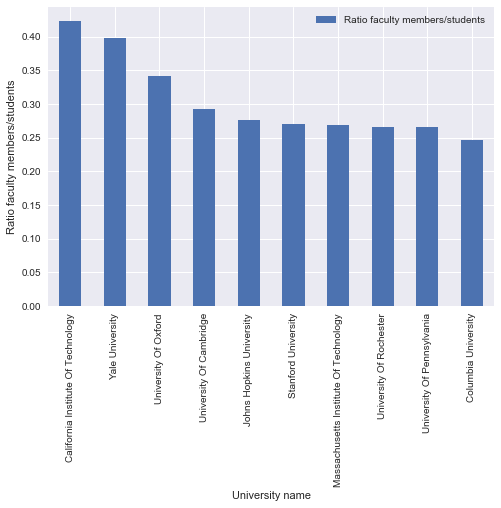

In [129]:
df_tu_QA = sort(df_tu, total_faculty_members, total_students, faculty_members_students_ratio)
reduced_plot(df_tu_QA, name, faculty_members_students_ratio, university_name, faculty_members_students_ratio)

# Question b)
I sort the dataframe as required and plot the 10 universities with the higher internationl students/total students ratio. It can be noted that 7 out of 10 universities are European, and 4 of these 7 are based in London. It's also interesting to notice that EPFL is second in this ranking, which means we are part of a very international campus.

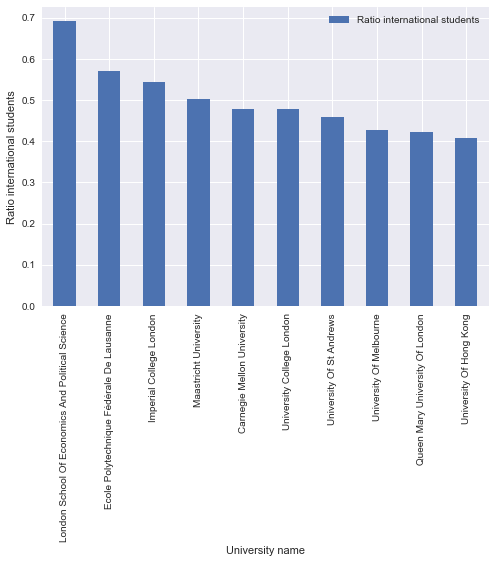

In [130]:
df_tu_QB = sort(df_tu, international_students, total_students, international_students_ratio)
reduced_plot(df_tu_QB, name, international_students_ratio, university_name, international_students_ratio)

# Question a) with country aggregation

What we did here is grouping the dataframe by country, then aggregating it by using the mean operator, thus obtaining a "representative university" for each country.
The results here are pretty different if compared to question a) without aggregation: UK is at the 9th place while US is at the 13th place here, while the previous question highlighted the fact that the 10 university with the highest faculty members/students ratio were American or English.
This may be explained by the fact that those 10 university are not representative of their country standard faculty members/students ratio: they're probably exceptions due to being extremely renowned. It is likely that this ratio is higher and more constant in country that ranked high like Russia.

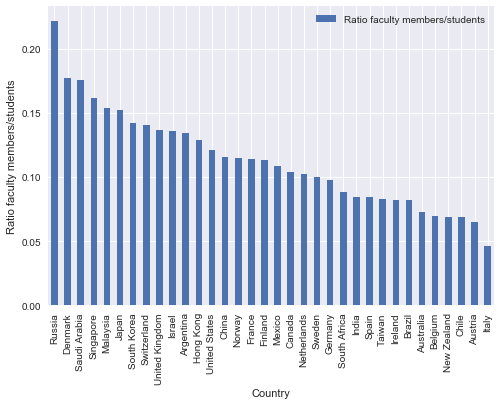

In [131]:
df_tu_country = group(df_tu, country)
df_tu_QAC = sort(df_tu_country, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAC, country, faculty_members_students_ratio, country, faculty_members_students_ratio)

# Question b) with country aggregation

What we did here is grouping the dataframe by country, then aggregating it by using the mean operator, thus obtaining a "representative university" for each country.
The results here are pretty coherent with the ones obtained without aggregating. We saw that 4 of the 10 university with higher international students were from London, and we can see that the UK is indeed at second place in the country ranking. Melbourne University and Honk Kong University were also in the ranking, and coherently enough Australia and Honk Kong are at first and third place. the presence of EPFL in the non-aggregated ranking is supported by Switzerland's 5th place in the aggregated ranking.

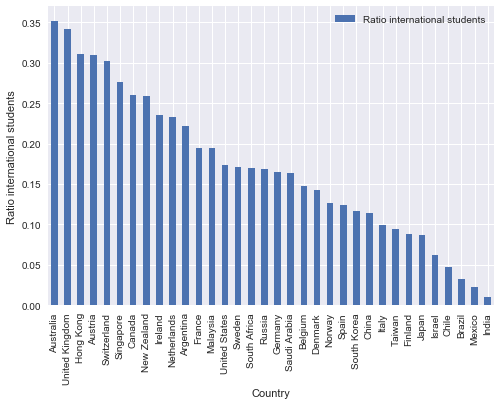

In [132]:
df_tu_QBC = sort(df_tu_country, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBC, country, international_students_ratio, country, international_students_ratio)

# Question a) with region aggregation

What we did here is grouping the dataframe by region, then aggregating it by using the mean operator, thus obtaining a "representative university" for each region.
We see Asia at first place, which could be explained if we look at the country-aggregated ranking, which sees Singapore, Malaysia, Japan and South Korea in the 4th-tth places. Unexpectedly North America is second place, even if US ranked 13th in the country ranking. This is hard to explain. Europe 3rd place is backed by Russia first place in the previous ranking.

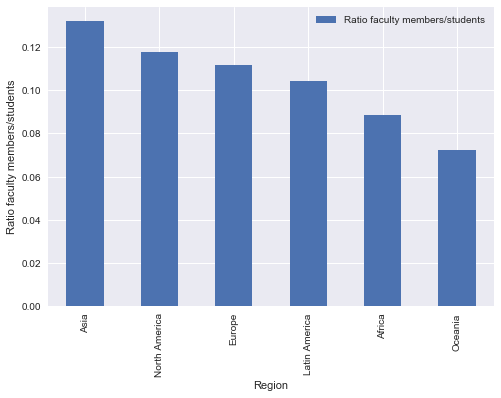

In [133]:
df_tu_region = group(df_tu, region)
df_tu_QAD = sort(df_tu_region, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAD, region, faculty_members_students_ratio, region, faculty_members_students_ratio)

# Question b) with region aggregation

What we did here is grouping the dataframe by region, then aggregating it by using the mean operator, thus obtaining a "representative university" for each region.
The result are coherent with the previous one: Australia was first in the country-aggregated ranking and Oceania is first in the region-aggregated ranking. UK was second and Europe is second. Still hard to justify North America's position.

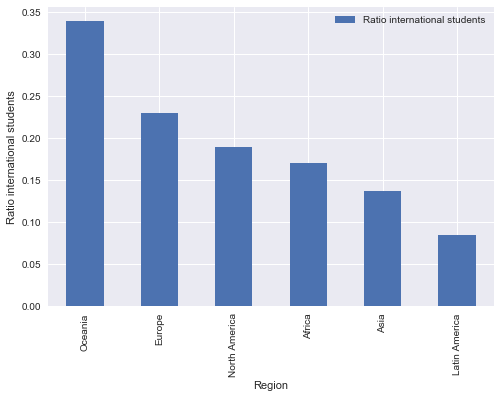

In [134]:
df_tu_QBD = sort(df_tu_region, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBD, region, international_students_ratio, region, international_students_ratio)

## Question 2: Times Higher Education webpage

In [135]:
def prepare_uni_data_the(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['name']))
    uni_infos['Country'] = uni['location']
    uni_infos['Rank Time Higher Education'] = clean_number(uni['rank'])
    uni_infos['Number of Students'] = clean_number(uni['stats_number_students'])
    uni_infos['Student/Staff Ratio'] = clean_number(uni['stats_student_staff_ratio'])
    uni_infos['% of International Students'] = clean_number(uni['stats_pc_intl_students'])
    return uni_infos
res = get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json', 'html')
json_ranking_the = json.loads(res.text)['data']
json_ranking_the = sorted(json_ranking_the, key=lambda k: clean_number(k['rank']))[:200]
df_the = pd.DataFrame(list(map(prepare_uni_data_the,json_ranking_the)))
# # get_missing_uni(df)

In [136]:
# df_the.to_pickle('df_the.xz')
df_the = pd.read_pickle('df_the.xz')
# df = df_tu.merge(df_the, 'outer', on='Name')
# df = get_missing_uni(df).set_index('Name').combine_first(df.set_index('Name'))
df_the

,% of International Students,Country,Name,Number of Students,Rank Time Higher Education,Student/Staff Ratio
0,38,United Kingdom,University Of Oxford,20409,1,112
1,35,United Kingdom,University Of Cambridge,18389,2,109
2,27,United States,California Institute Of Technology,2209,3,65
3,22,United States,Stanford University,15845,3,75
4,34,United States,Massachusetts Institute Of Technology,11177,5,87
5,26,United States,Harvard University,20326,6,89
6,24,United States,Princeton University,7955,7,83
7,55,United Kingdom,Imperial College London,15857,8,114
8,25,United States,University Of Chicago,13525,9,62
9,38,Switzerland,Eth Zurich - Swiss Federal Institute Of Techno...,19233,10,146


# Question a)
I sort the dataframe by using the values contained in the 'Student/Staff Ratio' column, assuming 'staff' is another name for 'faculty members'. 
What we are looking for is the 'Staff/student' Ratio, which can be visualized by sorting in ascending order according to the 'Student/Staff Ratio'.
The results are of course different compared to the respective ones in part 1, however US universities still dominate the board (7 out of 10).

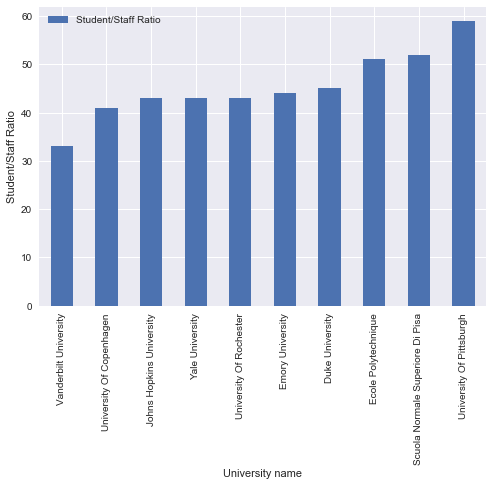

In [137]:
#NOTE! student/staff ratio value are multiplied x10 during the filtering, no difference for sorting.
#NOTE! ascending order in student/staff ratio == descending order in staff/student ratio
# and we're looking for staff/student ratio (assuming staff == faculty members)
df_the_QA = df_the.sort_values([students_staff_ratio], ascending=True)
reduced_plot(df_the_QA, name, students_staff_ratio, university_name, students_staff_ratio)

# Question b)
I sort the dataframe by using the values contained in the '% of international students" column.
The result are very similar to those of part 1: the same London universities as well as EPFL and Honk Kong university appears.

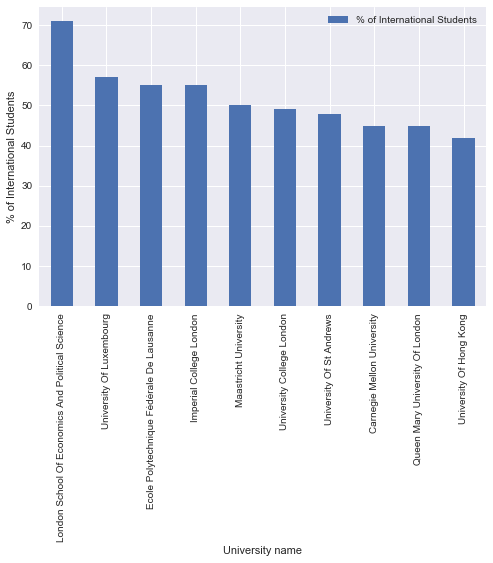

In [138]:
df_the_QB = df_the.sort_values([pc_international_students], ascending=False)
reduced_plot(df_the_QB, name, pc_international_students, university_name, pc_international_students)

# Question a) with country aggregation

The result is different but somehow consistent with part 1: Russia is still first place, while Japan, Taiwan, and Singapore for example are still high in the rankings.

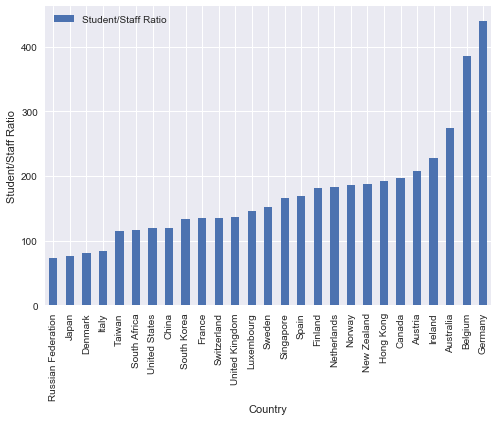

In [139]:
df_the_country = group(df_the, country)
df_the_QAC = df_the_country.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAC, country, students_staff_ratio, country, students_staff_ratio)

# Question b) with country aggregation

The result is coherent with question 2b) non-aggregated: US, UK and Switzerland are very high in the graduatory.
The main difference with part 1 is that here United States are high in the ranking, which gives an overall more coherent picture.

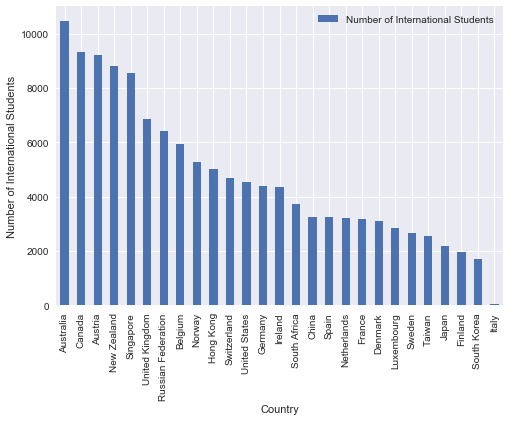

In [140]:
#NOTE i don't use math.ceil() on number of international students because i couldn't implement swiftly.
#less chanches of ties anyway
df_temp = df_the
df_temp[number_international_students] = df_temp[pc_international_students]*df_temp[number_students]/100
df_the_QBC = group(df_temp, country)
df_the_QBC = df_the_QBC.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBC, country, number_international_students, country, number_international_students)

In [141]:
# a method to map country to regions
def countryRegionMapping(df_to_map):
    df_with_mapping = df_tu[[country, region]].drop_duplicates()
    df_mapped = df_to_map.merge(df_with_mapping)
    return df_mapped

# Question a) with region aggregation

The result is hard to explain. Apparently the ranking is reversed (Raph Albane ici aucune idée, faute peut-etre?)

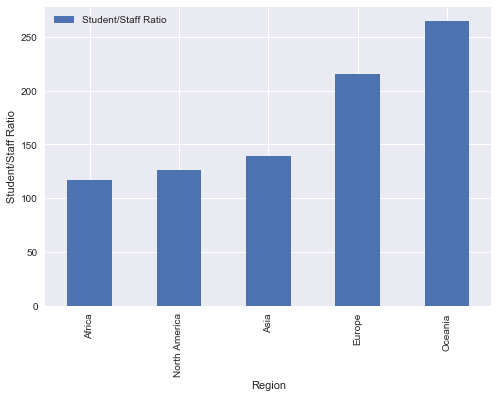

In [142]:
df_mapped = countryRegionMapping(df_the)
df_the_region = group(df_mapped, region)
df_the_QAD = df_the_region.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAD, region, students_staff_ratio, region, students_staff_ratio)

# Question b) with region aggregation

The result is coherent with all the previous ones, with European and North American universities at the top.

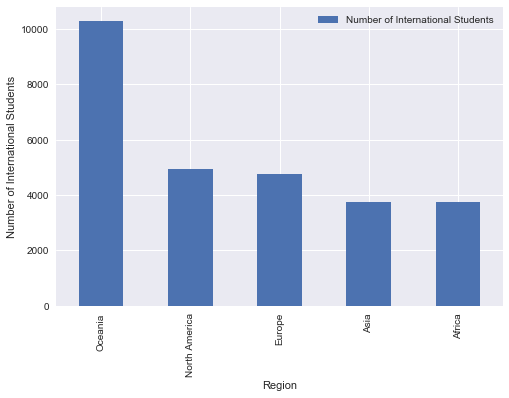

In [143]:
df_mapped = countryRegionMapping(df_temp)
df_the_QBD = group(df_mapped, region)
df_the_QBD = df_the_QBD.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBD, region, number_international_students, region, number_international_students)

# Question 3: dataframes merging

In [144]:
def complete_with_tu(name):
    for uni in json_ranking_tu:
        if normalize_name(uni['title']) == name:
            return prepare_uni_data_tu(uni)
        
def complete_with_the(name):
    for uni in json_ranking_the:
        if normalize_name(uni['name']) == name:
            return prepare_uni_data_the(uni)

def get_missing_uni(df):
    completion = []
    for missing in df[df['Rank Top Universities'].isnull()]['Name']:
        tu_data = complete_with_tu(missing)
        if tu_data:
            completion.append(tu_data)
    for missing in df[df['Rank Time Higher Education'].isnull()]['Name']:
        the_data = complete_with_the(missing)
        if the_data:
            completion.append(the_data)
    return pd.DataFrame(completion)

merged_df = df_tu.merge(df_the, 'outer', on=['Name'])

filtered_merged_df = merged_df[merged_df['Country_x'].notnull() & merged_df['Country_y'].notnull()]
filtered_merged_df
# merged_df = merged_df.merge(get_missing_uni(merged_df), 'left', on=['Name'])
# df[df['Country'].isnull()]
# df[df['Name'].str.contains('Gothenburg')]

,Country_x,International faculty members,International students,Name,Rank Top Universities,Region,Total faculty members,Total students,% of International Students,Country_y,Number of Students,Rank Time Higher Education,Student/Staff Ratio,Number of International Students
0,United States,1679.0,3717.0,Massachusetts Institute Of Technology,1.0,North America,2982.0,11067.0,34.0,United States,11177.0,5.0,87.0,3800.18
1,United States,2042.0,3611.0,Stanford University,2.0,North America,4285.0,15878.0,22.0,United States,15845.0,3.0,75.0,3485.90
2,United States,1311.0,5266.0,Harvard University,3.0,North America,4350.0,22429.0,26.0,United States,20326.0,6.0,89.0,5284.76
3,United States,350.0,647.0,California Institute Of Technology,4.0,North America,953.0,2255.0,27.0,United States,2209.0,3.0,65.0,596.43
4,United Kingdom,2278.0,6699.0,University Of Cambridge,5.0,Europe,5490.0,18770.0,35.0,United Kingdom,18389.0,2.0,109.0,6436.15
5,United Kingdom,2964.0,7353.0,University Of Oxford,6.0,Europe,6750.0,19720.0,38.0,United Kingdom,20409.0,1.0,112.0,7755.42
6,United Kingdom,2554.0,14854.0,University College London,7.0,Europe,6345.0,31080.0,49.0,United Kingdom,30304.0,16.0,105.0,14848.96
7,United Kingdom,2071.0,8746.0,Imperial College London,8.0,Europe,3930.0,16090.0,55.0,United Kingdom,15857.0,8.0,114.0,8721.35
8,United States,635.0,3379.0,University Of Chicago,9.0,North America,2449.0,13557.0,25.0,United States,13525.0,9.0,62.0,3381.25
9,Switzerland,1886.0,7563.0,Eth Zurich - Swiss Federal Institute Of Techno...,10.0,Europe,2477.0,19815.0,38.0,Switzerland,19233.0,10.0,146.0,7308.54


In [145]:
#missing = get_missing_uni(merged_df)
#missing.drop('Country', axis=1, inplace=True)

In [146]:
#merged_df = missing.set_index('Name').combine_first(merged_df.set_index('Name')).reset_index()
#merged_df

In [147]:
null_df = merged_df[merged_df['Rank Time Higher Education'].isnull() | merged_df['Rank Top Universities'].isnull()]
null_df = merged_df[merged_df['Rank Time Higher Education'].isnull()]
null_df

,Country_x,International faculty members,International students,Name,Rank Top Universities,Region,Total faculty members,Total students,% of International Students,Country_y,Number of Students,Rank Time Higher Education,Student/Staff Ratio,Number of International Students
23,United Kingdom,1513.0,9451.0,King's College London,23.0,Europe,3650.0,23780.0,NaN,NaN,NaN,NaN,NaN,NaN
40,South Korea,147.0,584.0,Kaist - Korea Advanced Institute Of Science & ...,41.0,Asia,1250.0,9826.0,NaN,NaN,NaN,NaN,NaN,NaN
42,France,75.0,374.0,"Ecole Normale Supérieure, Paris",43.0,Europe,178.0,1907.0,NaN,NaN,NaN,NaN,NaN,NaN
55,Japan,191.0,1071.0,Tokyo Institute Of Technology,56.0,Asia,1563.0,9832.0,NaN,NaN,NaN,NaN,NaN,NaN
62,Japan,296.0,2106.0,Osaka University,63.0,Asia,2814.0,22760.0,NaN,NaN,NaN,NaN,NaN,NaN
65,Germany,674.0,5084.0,Ludwig-Maximilians-Universität München,66.0,Europe,3274.0,35055.0,NaN,NaN,NaN,NaN,NaN,NaN
67,Germany,756.0,5298.0,Ruprecht-Karls-Universität Heidelberg,68.0,Europe,3908.0,28852.0,NaN,NaN,NaN,NaN,NaN,NaN
74,Argentina,3165.0,27109.0,Universidad De Buenos Aires,75.0,Latin America,16421.0,122301.0,NaN,NaN,NaN,NaN,NaN,NaN
75,Japan,264.0,1604.0,Tohoku University,76.0,Asia,3411.0,17827.0,NaN,NaN,NaN,NaN,NaN,NaN
89,South Korea,339.0,3638.0,Korea University,90.0,Asia,3745.0,25892.0,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
filtered_merged_df = merged_df[merged_df['Rank Time Higher Education'].notnull() & merged_df['Rank Top Universities'].notnull()]
filtered_merged_df

,Country_x,International faculty members,International students,Name,Rank Top Universities,Region,Total faculty members,Total students,% of International Students,Country_y,Number of Students,Rank Time Higher Education,Student/Staff Ratio,Number of International Students
0,United States,1679.0,3717.0,Massachusetts Institute Of Technology,1.0,North America,2982.0,11067.0,34.0,United States,11177.0,5.0,87.0,3800.18
1,United States,2042.0,3611.0,Stanford University,2.0,North America,4285.0,15878.0,22.0,United States,15845.0,3.0,75.0,3485.90
2,United States,1311.0,5266.0,Harvard University,3.0,North America,4350.0,22429.0,26.0,United States,20326.0,6.0,89.0,5284.76
3,United States,350.0,647.0,California Institute Of Technology,4.0,North America,953.0,2255.0,27.0,United States,2209.0,3.0,65.0,596.43
4,United Kingdom,2278.0,6699.0,University Of Cambridge,5.0,Europe,5490.0,18770.0,35.0,United Kingdom,18389.0,2.0,109.0,6436.15
5,United Kingdom,2964.0,7353.0,University Of Oxford,6.0,Europe,6750.0,19720.0,38.0,United Kingdom,20409.0,1.0,112.0,7755.42
6,United Kingdom,2554.0,14854.0,University College London,7.0,Europe,6345.0,31080.0,49.0,United Kingdom,30304.0,16.0,105.0,14848.96
7,United Kingdom,2071.0,8746.0,Imperial College London,8.0,Europe,3930.0,16090.0,55.0,United Kingdom,15857.0,8.0,114.0,8721.35
8,United States,635.0,3379.0,University Of Chicago,9.0,North America,2449.0,13557.0,25.0,United States,13525.0,9.0,62.0,3381.25
9,Switzerland,1886.0,7563.0,Eth Zurich - Swiss Federal Institute Of Techno...,10.0,Europe,2477.0,19815.0,38.0,Switzerland,19233.0,10.0,146.0,7308.54


# Question 4: Exploratory analysis

Helper function described below.

In [149]:
#converts variable type into int so it's possible to compute correlation
def factorize(df, variable):
    labels, uniques = pd.factorize(df[variable])
    df[variable] = labels
    
#computes correlation and convert variable type if necessary
def compute_correlation(x_variable, y_variable, x_needs_factorization = False, y_needs_factorization = False):
    correlation_df = filtered_merged_df[[x_variable, y_variable]]
    if x_needs_factorization:
        factorize(correlation_df, x_variable)
    if y_needs_factorization:
        factorize(correlation_df, y_variable)
    return correlation_df.corr()

In [150]:
#further column names
countryx = 'Country_x'
international_faculty_members = 'International faculty members'
rank_tu = 'Rank Top Universities'
rank_the = 'Rank Time Higher Education'

The correlation between country and number of international students for the topUniversites ranking (TU ranking) is very weak, which is kinda consistent with the fact that there are renowned university a bit everywhere.

In [151]:
#correlation country-number of international students for tu
compute_correlation(countryx, international_students, x_needs_factorization = True)

,Country_x,International students
Country_x,1.000000,-0.125476
International students,-0.125476,1.000000


Same as above for the Times Higher Education ranking (THE ranking).

In [152]:
#correlation country-number of international students for the
compute_correlation(countryx, number_international_students, x_needs_factorization = True)

,Country_x,Number of International Students
Country_x,1.000000,-0.187494
Number of International Students,-0.187494,1.000000


The value of the correlation in this case justifies the hypothesis of a moderate relationship between the number of international faculty members and number of international students. This makes sense: a university that is internationally recognized lures in both faculty members and students from abroad.

In [153]:
#correlation number of international faculty members - number of international students for tu
compute_correlation(international_faculty_members, international_students)

,International faculty members,International students
International faculty members,1.000000,0.567818
International students,0.567818,1.000000


The correlation between country and ranking for the TU ranking is weak, suggesting there's no linear relationship between the two variables

In [154]:
#correlation country-ranking for tu
compute_correlation(countryx, rank_tu, x_needs_factorization = True)

,Country_x,Rank Top Universities
Country_x,1.000000,0.281257
Rank Top Universities,0.281257,1.000000


The correlation between country and ranking for the THE ranking website suggests a moderate linear relationship.

In [155]:
#correlation country-ranking for the
compute_correlation(countryx, rank_the, x_needs_factorization = True)

,Country_x,Rank Time Higher Education
Country_x,1.00000,0.44463
Rank Time Higher Education,0.44463,1.00000


the correlation between ranking and region is close to 0 for TU ranking. No linear relationship.

In [156]:
#correlation region-ranking for tu
compute_correlation(region, rank_tu, x_needs_factorization = True)

,Region,Rank Top Universities
Region,1.000000,-0.054574
Rank Top Universities,-0.054574,1.000000


the correlation between ranking and region is much higher for THE, which is consistent with the higher ranking-country correlation.

In [157]:
#correlation region-ranking for the
compute_correlation(region, rank_the, x_needs_factorization = True)

,Region,Rank Time Higher Education
Region,1.000000,0.327083
Rank Time Higher Education,0.327083,1.000000


There's a tangible linear relationship between number of faculty members and number of students, which might be given by how big a university is: the bigger it is, the more students and faculty members it has.

In [158]:
#correlation total faculty members - total students for tu
compute_correlation(total_faculty_members, total_students)
#kinda high correlation - makes sense

,Total faculty members,Total students
Total faculty members,1.000000,0.593186
Total students,0.593186,1.000000


There's a strong correlation between the TU and THE ranking, which makes sense since the ranking process should be a very objective one, and therefore both websites should rank universities in a similar way.

In [159]:
#correlation rank in first website - rank in second website
compute_correlation(rank_tu, rank_the)
# very high correlation thanks god - makes sense

,Rank Top Universities,Rank Time Higher Education
Rank Top Universities,1.000000,0.704096
Rank Time Higher Education,0.704096,1.000000


# Question 5: best university

In [160]:
#further column names
mean_rank = 'mean rank'

simply take the average of the two ranking associated to each university. The result is overall consistent with the previous ones: renowned American and English university are at the top of the ranking, plus ETHZ.

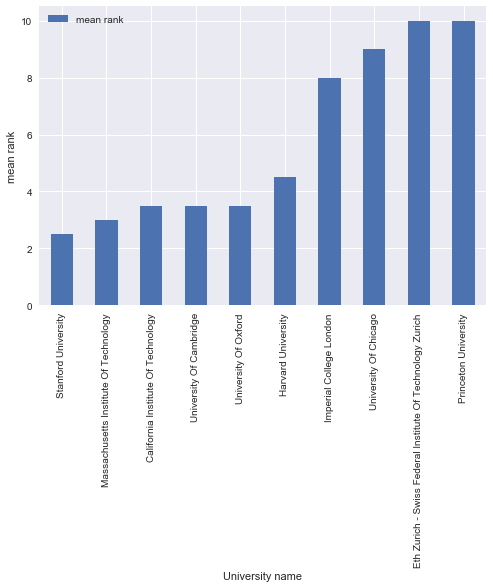

In [161]:
filtered_merged_df[mean_rank] = (filtered_merged_df[rank_tu]+filtered_merged_df[rank_the])/2
mean_ranking_df = filtered_merged_df.sort_values(by=[mean_rank], ascending=True)
reduced_plot(mean_ranking_df, name, mean_rank, university_name, mean_rank)